# Learning Objectives

Use few-shot prompting to build LLM applications for classification tasks.


# Setup

In [6]:
!pip install -q openai==1.23.2 datasets

In [7]:
import numpy as np

from openai import OpenAI
from datasets import load_dataset
from google.colab import userdata
from tqdm import tqdm

In [8]:
anyscale_api_key = userdata.get('anyscale_api_key')

In [9]:
client = OpenAI(
    base_url="https://api.endpoints.anyscale.com/v1",
    api_key=anyscale_api_key
)

In [10]:
model_name = 'mlabonne/NeuralHermes-2.5-Mistral-7B'

# Text - Label Tasks

## Overview

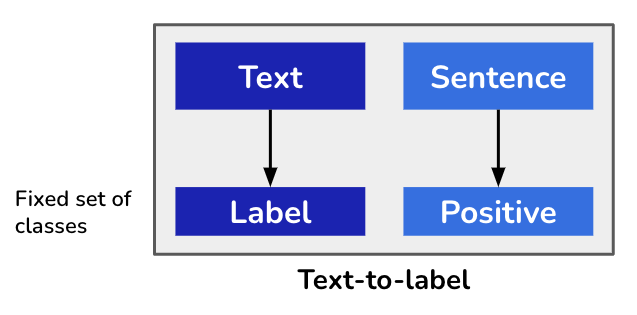

Text-to-label tasks are a core NLP task where the objective is to classify input text to a predefined set of classes. LLMs achieve high accuracy on these with a far lesser data requirement and no model training. In this notebook we will look at how LLM prompts could be designed and evaluated for text-to-label tasks using sentiment analysis as an example. The approach in this notebook can be extended to any other classification task.

We begin by presenting a workflow for prompt design and evaluation for classification tasks.

## Workflow

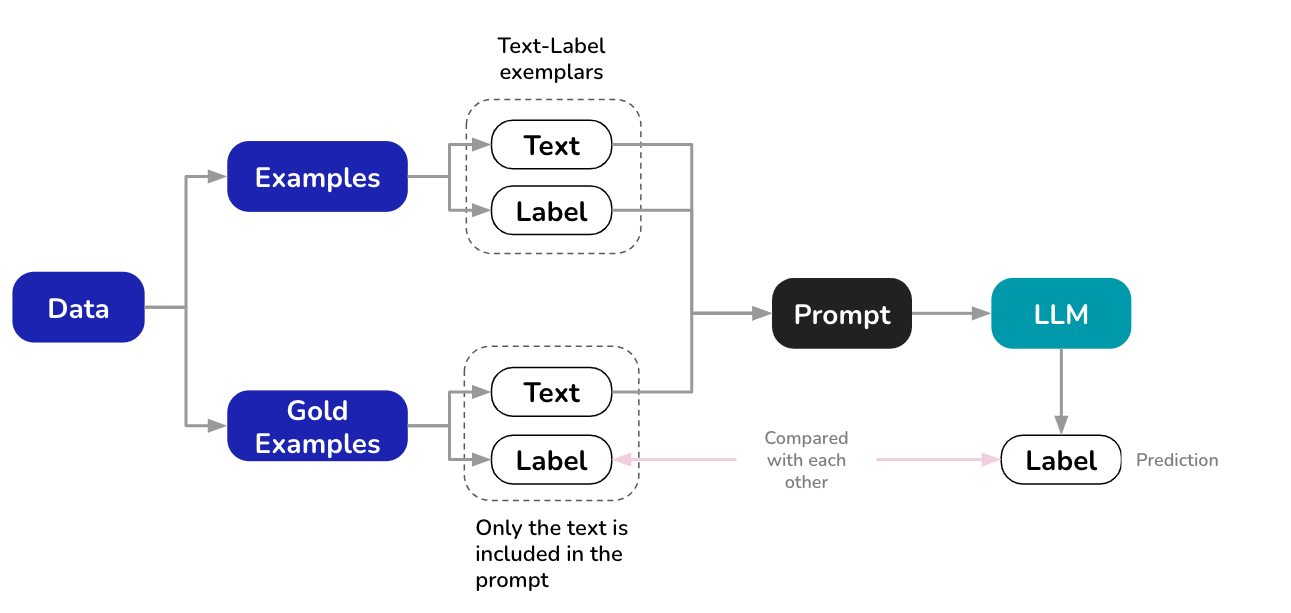

As indicated in the above figure, we do need data to prime the LLM for classification tasks. However, when using LLMs, the requirement on data is several order of magnitudes lesser since there is no training involved. Data used to achieve classification tasks comprises examples and gold examples. Examples are input-output exemplars (usually not more than 8) included in the prompt to prime it for expected label generation. Gold examples are inputs for evaluation where we have ground truth available and predictions from the LLM for the inputs is compared with the ground truths. We choose the best *prompt* as the one that scores high on predefined metrics (e.g., accuracy, F1 score) on the set of gold examples.

Note that we are avoiding the usage of train and test data here to reinforce the idea that there is no model training involved here. While conceptually the idea of examples and gold examples is similar to train and test data, the similarity ends there since there is no model training.

## Evaluation

Performance of prompts for classification tasks can be measured using accuracy, and/or F1 score.

**Accuracy:**

Accuracy measures the proportion of correctly classified instances out of the total number of instances. It is calculated as the number of true positives (correctly classified instances) divided by the total number of instances. Accuracy provides a straightforward measure of a model's overall performance, but it can be misleading if the classes are imbalanced.

**F1 Score:**

The F1 score, also known as the F1 measure or F-score, is a measure of the model's accuracy and precision. It is calculated as the harmonic mean of precision and recall. Precision measures the proportion of true positives among all predicted positive instances, while recall measures the proportion of true positives among all actual positive instances. The F1 score provides a more comprehensive evaluation of a model's performance, as it takes into account both precision and recall.

Let us now implement this workflow for sentiment analysis on a sample of IMDB reviews.

# Sentiment Analysis

## Prompt Design

We will design a few-shot prompt for sentiment analysis. We first assemble a set of examples (input-output exemplars) as a part of the few-shot prompt. Then we create the prompt in the Anyscale API format.

To evaluate the performance of the *prompt* we will use a set of *gold examples*, that is, a set of examples that is not presented to the model as a part of the prompt.  

**Examples and Gold Examples**

A set of examples and gold examples for sentiment classification of IMDB movie reviews is hosted on a HuggingFace dataset. Let us load this data and take a look at the samples in this data.

In [12]:
imdb = load_dataset("pgurazada1/imdb")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating examples split:   0%|          | 0/32 [00:00<?, ? examples/s]

Generating gold_examples split:   0%|          | 0/32 [00:00<?, ? examples/s]

As is evident from the above output, the data set has 32 samples as examples and 32 samples as gold examples.

In [13]:
imdb_examples_df = imdb['examples'].to_pandas()
imdb_gold_examples_df = imdb['gold_examples'].to_pandas()

In [14]:
imdb_examples_df.shape, imdb_gold_examples_df.shape

((32, 2), (32, 2))

In [15]:
imdb_examples_df.sample(4)

text  label
24  Greenaway's films pose as clever, erudite and ...      0
18  Maybe you shouldn't compare, but Wild Style an...      0
30  I saw this film last night (about 102 minutes)...      0
11  "Ah Ritchie's made another gangster film with ...      1

As the above outputs indicate, there are 32 examples and 32 gold examples. We will sample from the examples to create the few shot prompt and evaluate the prompt on all 32 gold examples.

**Assembling the prompt**

In [11]:
system_message = """
Classify movie reviews in the input as positive or negative in sentiment.
Do not explain your answer. Your answer should only contain the label: positive or negative.
"""

In [16]:
few_shot_prompt = [{'role':'system', 'content': system_message}]

We need to iterate over the rows of the examples DataFrame to append these examples as `user` and `assistant` messages to the few-shot prompt. We achieve this using the `iterrows` method.

In [17]:
for index, row in imdb_examples_df.iterrows():
    print('Example Review:')
    print(row[0])
    print('Example Label:')
    print(row[1])
    break

Example Review:
i just saw Dick Tracy and I thought it was terrible. The paintings in the background of the cities looked awful. Also the mob characters looked too weird. Warren Beatty didn't do an awful job as Dick Tracy but it was definetely not one of his better performances. Madonna should just stick to singing. Glenne Headly did a good job in this movie. I gave this movie a 2/10 just because of the amazing acting by Al Pacino. It wasn't a high note in his career but he still did a good job.
Example Label:
0


Notice that the label is an integer. However, LLMs accept only strings. So we need to convert the integer label to a string label as we assemble the few-shot prompt. Let us assemble a few-shot prompt with 4 examples.

In [18]:
for index, row in imdb_examples_df.sample(4).iterrows():
    example_review = row[0]
    example_label = row[1]

    few_shot_prompt.append(
        {
            'role': 'user',
            'content': example_review
        }
    )

    few_shot_prompt.append(
        {
            'role': 'assistant',
            'content': str(example_label) # LLMs accept only string inputs
        }
    )

In [19]:
few_shot_prompt

[{'role': 'system',
  'content': '\nClassify movie reviews in the input as positive or negative in sentiment.\nDo not explain your answer. Your answer should only contain the label: positive or negative.\n'},
 {'role': 'user',
  'content': 'Vodka Lemon is a charming, yet extremely uneven Arminian film that will delight some and bore others. Though reasonably well-crafted, the film lacks any real "zing", relying instead on many scenes that will seem commonplace to the astute art-house viewer. The film contains a handful of moments of sheer cinematic brilliance, unfortunately, they deserve a film worthy of their genius. Too dark to be a dark comedy and to light to be a serious drama, Vodka Lemon will leave many views disoriented and ultimately disgruntled. You may laugh, but these moments will be few and far between amid a sea of washed out snow filled landscapes and a seemingly endless series of bus rides. A noble effort, ultimately done in by lack of narrative cohesion.'},
 {'role': 'a

We now have 4 examples in the few shot prompt that is ready for use. Before we deploy this prompt, we need to get an estimate of the performance of this prompt. Here is where we use gold examples to estimate the accuracy.

## Evaluation

In [23]:
predictions, ground_truths = [], []

In [24]:
for index, row in tqdm(imdb_gold_examples_df.iterrows()):
    gold_review = row[0]
    gold_label = row[1]

    user_input = [{'role':'user', 'content': gold_review}]

    response = client.chat.completions.create(
        model=model_name,
        messages=few_shot_prompt + user_input
    )

    predictions.append(int(response.choices[0].message.content)) # convert the string label back to int
    ground_truths.append(gold_label)

32it [01:15,  2.37s/it]


In [25]:
predictions = np.array(predictions)
ground_truths = np.array(ground_truths)
(predictions == ground_truths).mean()

0.90625

The output above indicates that the accuracy of the few-shot prompt is about 90% on gold examples. More fine-grained evaluation (e.g., F1 score) could also be used to establish the estimated accuracy of the prompt.

>Increase the number of examples in the few-shot prompt to 8 and evaluate the performance of the prompt. Does doubling examples in a few-shot prompt help increase accuracy? Make a guess before you implement the few-shot prompt.

# Next Steps

After a few-shot prompt is assembled and evaluated, the prompt is wrapped within a server and deployed.

In [ ]:
# @title Movie Sentiment Analyzer

movie_review = "Worth the entertainment value of a rental, especially if you like action movies.      This one features the usual car chases, fights with the great Van Damme kick style, shooting battles with the 40 shell load shotgun, and even terrorist style bombs.      All of this is entertaining and competently handled but there is nothing that really blows you away if you've seen your share before.     <br /><br />The plot is made interesting by the inclusion of a rabbit, which is clever but hardly profound.      Many of the characters are heavily stereotyped -- the angry veterans, the terrified illegal aliens, the crooked cops, the indifferent feds, the bitchy tough lady station head, the crooked politician, the fat federale who looks like he was typecast as the Mexican in a Hollywood movie from the 1940s.      All passably acted but again nothing special.<br /><br />I thought the main villains were pretty well done and fairly well acted.      By the end of the movie you certainly knew who the good guys were and weren't.      There was an emotional lift as the really bad ones got their just deserts.      Very simplistic, but then you weren't expecting Hamlet, right? The only thing I found really annoying was the constant cuts to VDs daughter during the last fight scene.     <br /><br />Not bad. Not good. Passable 4." # @param {type:"string"}

system_message = """
Classify movie reviews in the input as positive or negative in sentiment.
Do not explain your answer. Your answer should only contain the label: positive or negative.
"""

user_input = [{'role':'user', 'content': movie_review}]

few_shot_prompt = [{'role':'system', 'content': system_message}]

for index, row in imdb_examples_df.sample(4).iterrows():
    example_review = row[0]
    example_label = row[1]

    few_shot_prompt.append(
        {
            'role': 'user',
            'content': example_review
        }
    )

    few_shot_prompt.append(
        {
            'role': 'assistant',
            'content': str(example_label) # LLMs accept only string inputs
        }
    )

response = client.chat.completions.create(
    model=model_name,
    messages=few_shot_prompt + user_input
)

prediction = int(response.choices[0].message.content)

if prediction == 1:
    print("Sentiment: Positive")
else:
    print("Sentiment: Negative")


Sentiment: Positive


In [ ]:
sample_review = [
    """
    Worth the entertainment value of a rental, especially if you like action movies.
    This one features the usual car chases, fights with the great Van Damme kick style, shooting battles with the 40 shell load shotgun, and even terrorist style bombs.
    All of this is entertaining and competently handled but there is nothing that really blows you away if you've seen your share before.
    <br /><br />The plot is made interesting by the inclusion of a rabbit, which is clever but hardly profound.
    Many of the characters are heavily stereotyped -- the angry veterans, the terrified illegal aliens, the crooked cops, the indifferent feds, the bitchy tough lady station head, the crooked politician, the fat federale who looks like he was typecast as the Mexican in a Hollywood movie from the 1940s.
    All passably acted but again nothing special.<br /><br />I thought the main villains were pretty well done and fairly well acted.
    By the end of the movie you certainly knew who the good guys were and weren't.
    There was an emotional lift as the really bad ones got their just deserts.
    Very simplistic, but then you weren't expecting Hamlet, right? The only thing I found really annoying was the constant cuts to VDs daughter during the last fight scene.
    <br /><br />Not bad. Not good. Passable 4.
    """
]

# Datasets for practise

## Emotion Classification

Explore the following data set, compose a few-shot prompt for emotion classification and evaluate its accuracy.

In [35]:
emotion_data = load_dataset("pgurazada1/emotion")

Generating examples split:   0%|          | 0/32 [00:00<?, ? examples/s]

Generating gold_examples split:   0%|          | 0/32 [00:00<?, ? examples/s]

In [36]:
emotion_data['examples'].to_pandas().sample(3)

text    label
22  i look back and i feel so incredibly satisfied...      joy
0   i came home one day and discovered that my sis...    anger
1   i not feel like going shopping afterward i was...  sadness

# Patent Abstract Classification

Explore the following data set, compose a few-shot prompt for patent abstract classification and evaluate its accuracy.

In [55]:
patent_data = load_dataset("pgurazada1/patent_classification")

Generating examples split:   0%|          | 0/32 [00:00<?, ? examples/s]

Generating gold_examples split:   0%|          | 0/32 [00:00<?, ? examples/s]

In [56]:
patent_data['examples'].to_pandas().sample(4)

text  \
30  a process for the deoxidation of a refractory ...   
29  a trellis system having a trellis structure th...   
4   the present invention is a non - ideal barrier...   
9   a clinical thermometer for detecting an infrar...   

                                  label  
30                Chemistry; Metallurgy  
29                  Fixed Constructions  
4   Performing Operations; Transporting  
9                               Physics